In [1]:
# !pip install requests

In [2]:
!pip install requests obspy

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.


In [3]:
# !pip3 install --break-system-packages requests obspy
# !pip3 install --break-system-packages requests pyzt

✅ Downloaded and saved file: mseed_files/Spurr_Last_0.25d_2025-03-25_T_103946.mseed


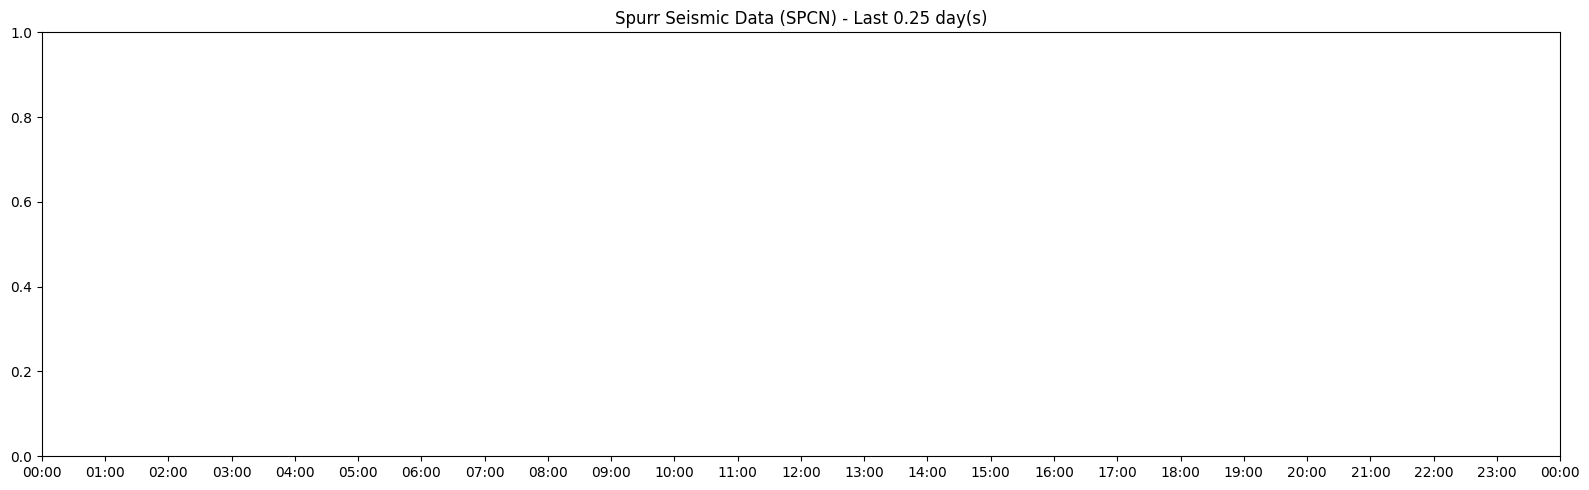

✅ Saved plot file: Plot_Files/Spurr_Last_0.25d_2025-03-25_T_103946.png
✅ Saved audio file: Audio_Files/Spurr_Last_0.25d_2025-03-25_T_103946.wav
✅ Generated marker file: Audio_Files/Spurr_Last_0.25d_2025-03-25_T_103946_Marker_File.txt


In [10]:
import requests
from datetime import datetime, timedelta, timezone
from obspy import read
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
import matplotlib.dates as mdates

# Function to compute time window based on number of days
def compute_time_window(days):
    # Manually calculate the Alaska timezone offset
    utc_offset = timedelta(hours=-9)  # Alaska is UTC-9
    end_time = datetime.now(timezone.utc) + utc_offset
    start_time = end_time - timedelta(days=days)
    end_str = end_time.strftime("%Y-%m-%dT%H:%M:%S")
    start_str = start_time.strftime("%Y-%m-%dT%H:%M:%S")
    return start_str, end_str, end_time

# Specify the number of days
days = .25  # Change this value to the desired number of days

# Step 1: Compute time window
start_str, end_str, end_time = compute_time_window(days)

# Create directories if they don't exist
mseed_dir = "mseed_files"
audio_marker_dir = "Audio_Files"
plot_dir = "Plot_Files"
os.makedirs(mseed_dir, exist_ok=True)
os.makedirs(audio_marker_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

# Create filenames with the new format
formatted_time = end_time.strftime('%Y-%m-%d_T_%H%M%S')
filename = os.path.join(mseed_dir, f"Spurr_Last_{days}d_{formatted_time}.mseed")
audio_filename = os.path.join(audio_marker_dir, f"Spurr_Last_{days}d_{formatted_time}.wav")
marker_filename = os.path.join(audio_marker_dir, f"Spurr_Last_{days}d_{formatted_time}_Marker_File.txt")
plot_filename = os.path.join(plot_dir, f"Spurr_Last_{days}d_{formatted_time}.png")

# Step 2: Check if file exists locally or fetch MiniSEED data
if os.path.exists(filename):
    print(f"✅ Using existing file: {filename}")
    st = read(filename)
else:
    url = "https://service.iris.edu/fdsnws/dataselect/1/query"
    params = {
        "net": "AV",
        "sta": "SPCN",
        "loc": "--",
        "cha": "BHZ",
        "start": start_str,
        "end": end_str,
        "format": "miniseed",
        "nodata": 404
    }
    response = requests.get(url, params=params)

    # Step 3: Save if successful
    if response.status_code == 200:
        with open(filename, "wb") as f:
            f.write(response.content)
        print(f"✅ Downloaded and saved file: {filename}")
        st = read(filename)
    else:
        print(f"❌ Error {response.status_code}: No data found or request failed.")
        exit()

# Step 4: Plot waveform - Modified approach
plt.figure(figsize=(16, 5))
st.plot(type='normal', show=False)  # Create plot but don't display yet
ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=tick_interval_hours))
plt.title(f"Spurr Seismic Data (SPCN) - Last {days} day(s)")
plt.tight_layout()
plt.savefig(plot_filename)
plt.show()  # Now show the plot
print(f"✅ Saved plot file: {plot_filename}")

# Step 5: Create audio file
# First normalize and prepare the data
tr = st[0].copy()
tr.detrend('demean')  # Remove mean
tr.taper(max_percentage=0.0001)  # Apply taper to reduce edge effects

# Set the sampling rate to 44100 Hz
tr.stats.sampling_rate = 500000

# Normalize amplitude to range [-1, 1] for audio
data = tr.data.astype(float)
max_amp = max(abs(data))
if max_amp > 0:  # Avoid division by zero
    data = data / max_amp

# Convert to 16-bit PCM
audio_data = (data * 32767).astype('int16')

# Save as WAV file
wavfile.write(audio_filename, int(tr.stats.sampling_rate), audio_data)
print(f"✅ Saved audio file: {audio_filename}")

# Function to generate marker file with actual data timestamps
def generate_marker_file_with_data_timestamps(stream, marker_interval_hours, filename):
    with open(filename, "w") as f:
        f.write("Marker file version: 1\n")
        f.write("Time format: Samples\n")
        
        # Extract the start time from the stream
        start_time = stream[0].stats.starttime
        end_time = stream[0].stats.endtime
        
        # Align the start time to the next hour
        if start_time.minute != 0 or start_time.second != 0 or start_time.microsecond != 0:
            start_time = start_time.replace(minute=0, second=0, microsecond=0) + timedelta(hours=1)
        
        current_time = start_time
        current_sample = (current_time - stream[0].stats.starttime) * stream[0].stats.sampling_rate
        marker_interval_samples = marker_interval_hours * 3600 * stream[0].stats.sampling_rate
        
        while current_time <= end_time:
            hour = current_time.hour
            formatted_time = current_time.strftime(f'%m/%d {hour}:%M:%S')
            f.write(f"{formatted_time}\t{int(current_sample)}\n")
            current_time += timedelta(hours=marker_interval_hours)
            current_sample += marker_interval_samples
        
        # Write the end marker
        end_hour = end_time.hour
        formatted_end_time = end_time.strftime(f'%m/%d {end_hour}:%M:%S')
        f.write(f"{formatted_end_time}\t{int(current_sample)}\n")
marker_interval_hours = 1  # Set the interval for markers in hours

generate_marker_file_with_data_timestamps(st, marker_interval_hours, marker_filename)
print(f"✅ Generated marker file: {marker_filename}")
